In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicProvider
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
from pylatexenc import *
from qiskit.circuit.library import QFT
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt
import math
from scipy.optimize import curve_fit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from qiskit import pulse                 
from qiskit.circuit import Parameter, Gate
import qiskit_ibm_provider
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

/var/folders/h3/mc63pl7x7kb9s61dxd7795jc0000gn/T/ipykernel_56990/138198082.py:18: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  import qiskit_ibm_provider


In [3]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="0f27a49a635e95723fc17420d91522041c25b954095b0b646f681bd4e449104fbb524532a6e4bef9c31bbb7372d605f73c6f474382e8b754f23b29e4adf8e9e0",overwrite=True)

In [4]:
# # Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

In [5]:
# Choose your backend
provider = IBMProvider()
backend_name = 'ibm_brisbane'
backend = provider.get_backend(backend_name)

backend_defaults = backend.defaults()

backend_properties = backend.properties()

In [6]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze

default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

default_anharmonicity = backend_properties.qubits[qubit][3].value # Default anharmonicity in GHz
print(f"Default anharmonicity is {default_anharmonicity} GHz.")

# scale data (specific to each device)
scale_factor = 1e-7

# number of shots for our experiments
NUM_SHOTS = 1024

Qubit 0 has an estimated frequency of 4.721908316964447 GHz.
Default anharmonicity is -0.31197865973435573 GHz.


In [7]:
# there are pulse parameters of the single qubit drive in IBM devices
x12_duration = 160
x12_sigma = 40
qubit_12_freq = 4409711500
pi_amp_12 = 0.2466186343423263

In [8]:
n_a = 1 ## ancilla
n_l = 2 ## clock register
n_b = 1 ## input vector

In [9]:
## Build 1->2 pulse
with pulse.build(backend=backend, default_alignment='sequential', name='x12 schedule') as x12_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(qubit_12_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=x12_duration,
                              amp=pi_amp_12,
                              sigma=x12_sigma,
                              name='x12_pulse'), drive_chan)
x12_gate = Gate("one_two_pulse", 1, [])

In [17]:
ancilla = QuantumRegister(n_a, name='ancilla')
b = QuantumRegister(n_b, name='b')
clock = QuantumRegister(n_l, name='clock')
measurement = ClassicalRegister(2, name='c')

initial_layout = [0, 1, 2, 3]

hhl = QuantumCircuit(ancilla, b, clock, measurement)

hhl.barrier()

## Put pulse on ancilla, ancilla is mapped to qubit 0 in the hardware

hhl.x(ancilla)
# hhl.append(x12_gate, [0])
# hhl.add_calibration(x12_gate, (0,), x12_sched, [])
hhl.barrier()
hhl.x(b)
hhl.barrier()
hhl.h(clock)
hhl.cu(-pi/2, -pi/2, pi/2, 3/4*pi, clock[0], b, label='U')
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$')
hhl.barrier()
hhl.h(clock[1])
hhl.cp(-np.pi/2, clock[0], clock[1])
hhl.h(clock[0])
hhl.swap(clock[0], clock[1])
hhl.barrier(label='$\psi_2$')
hhl.cry(pi, clock[0], ancilla)
hhl.cry(pi/3, clock[1], ancilla)
hhl.barrier()
hhl.measure(ancilla, measurement[0])
hhl.barrier()
hhl.swap(clock[0], clock[1])
hhl.h(clock[0])
hhl.cp(np.pi/2, clock[0], clock[1])
hhl.h(clock[1])
hhl.barrier()
hhl.cu(pi, 0, pi, 0, clock[1], b, label=r'$U^2$ inv')
hhl.cu(-pi/2, pi/2, -pi/2, -3/4*pi, clock[0], b, label='U inv')
hhl.h(clock)
hhl.barrier()
hhl.measure(b,measurement[1])

In [18]:
fig=hhl.draw('mpl', fold=1)
fig.savefig('circuit_improper_initialization_attack.pdf', bbox_inches='tight')

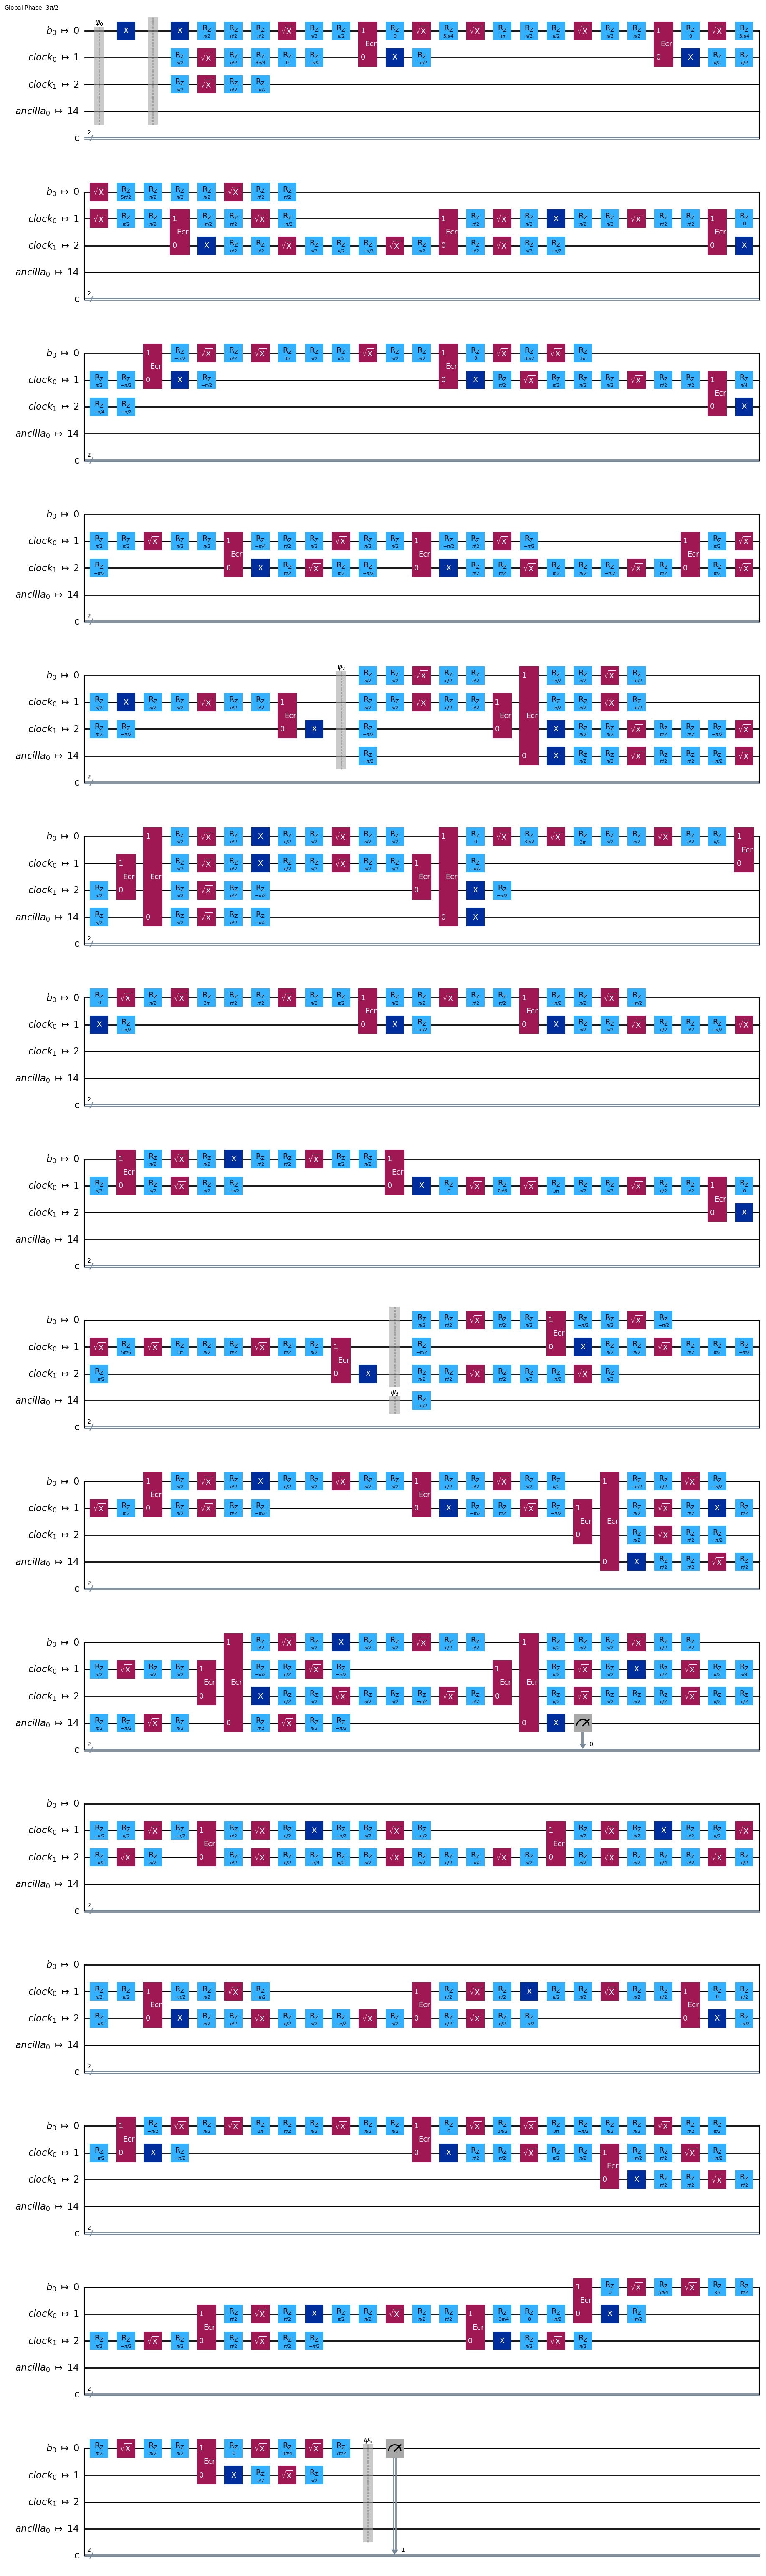

In [12]:
nShots = 10000
# hhl_tr = transpile(hhl, backend, layout_method='trivial', optimization_level=0)
hhl_tr = transpile(hhl, backend, initial_layout=initial_layout, optimization_level=0)
hhl_tr.draw(output='mpl', idle_wires=False)

In [41]:
# job = backend.run([hhl_tr], 
#                   meas_level=2, 
#                   meas_return='single', 
#                   shots=nShots)
# # job_monitor(job)
# job.job_id()

'cv8yzc5sgfsg008eb4zg'

In [47]:
# # job_id = "cv8bsxqqrk1g008r07b0"
# # job = service.job(job_id)
# job_monitor(job)

In [8]:
###### job_id = "cv8bt188gpc0008gegfg"
# job_id = "cv8ebhe8gpc0008gem30"
######job_id = "cv8emxvkfn8g008vp2wg"
# job_id = "cv8eba58gpc0008gem20"
###### job_id = "cv8emfhqrk1g008r0b5g"
job_id = "cv8ynme8gpc0008gg1wg"
###### job_id = "cv8yyy3emvv000850fmg"
###### job_id = "cv8yzc5sgfsg008eb4zg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# plot_histogram(counts, filename='attack_b_b=1_3.png')

1.2604422604422605


In [11]:
job_id = "cv8bsxqqrk1g008r07b0"
# job_id = "cv8bszqsgfsg008e9hd0"
# job_id = "cv8bt188gpc0008gegfg"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# plot_histogram(counts, filename='attack_b_higher_energy_3.png')

2.802787456445993


In [14]:
job_id = "cv89dhpm2bgg008kk8yg"
# job_id = "cv89dmpkfn8g008vnsgg"
# job_id = "cv89dpysgfsg008e9b5g"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# plot_histogram(counts, filename='attack_a_a=1_3.png')

0.8879821958456974


In [15]:
job_id = "cv88y8semvv00084yrd0"
# job_id = "cv88yc18gpc0008ge8yg"
# job_id = "cv88yg2emvv00084yrf0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
# plot_histogram(counts, filename='attack_a_higher_energy_1.png')

0.7905359946176272


In [19]:
job_id = "ctz31qpvz5fg0081c770"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print((counts['11'])/(counts['01']))
plot_histogram(counts, title='higher energy attack on HHL ancilla')

RuntimeJobNotFound: 'Job not found: 404 Client Error: Not Found for url: https://api.quantum.ibm.com/runtime/jobs/ctz31qpvz5fg0081c770?exclude_params=true. {"errors":[{"code":1291,"message":"Job not found. Job ID: ctz31qpvz5fg0081c770","solution":"Verify the job ID is correct, and that you have the correct access permissions.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}'

1.5625


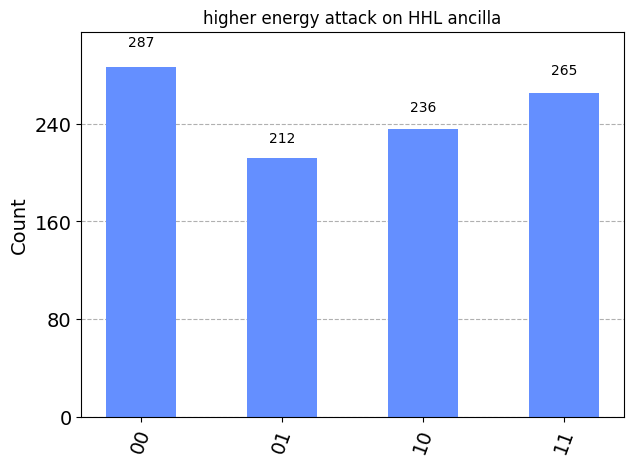

In [ ]:
job_id = "ctz23hpfhad0008tk3r0"
job = service.job(job_id)
result = job.result()
counts = result.get_counts()
print(((counts['11'])**2)/((counts['01'])**2))
plot_histogram(counts, title='higher energy attack on HHL ancilla')